# Download and Extract the Data
- Download the zipped file using CurlWidget chrome extention.
- Extracting content from the zipped file.

In [1]:
!wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en;q=0.9,hi-IN;q=0.8,hi;q=0.7,ta-IN;q=0.6,ta;q=0.5,en-GB;q=0.4,en-US;q=0.3" --header="Cookie: __utmz=3028652.1624856291.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utma=3028652.1813042570.1624856084.1624856291.1624950891.3" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'

--2021-07-14 03:14:45--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730753 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.37M  19.6MB/s    in 0.4s    

2021-07-14 03:14:46 (19.6 MB/s) - ‘ita-eng.zip’ saved [7730753/7730753]



In [2]:
import os
from zipfile import ZipFile 

with ZipFile("ita-eng.zip", 'r') as zip: 
    zip.extractall() 
del zip
lines = open(os.getcwd() + '/ita.txt', encoding='utf-8').read().split('\n')
print(f'No of lines: {len(lines)}')

No of lines: 352041


# Configuration

In [3]:
batch_size = 128  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 200000  # Number of samples to train on.

# Data Preprocessing
- Formulating text into a proper sentences.
- Normalizing strings and removing unwanted characters.
- Tokenizing characters.

In [4]:
print(lines[0])
print('-'*100) 
print(lines[800])
print('-'*100) 
print(lines[3500])
print('-'*100) 
print(lines[6000])
print('-'*100) 

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)
----------------------------------------------------------------------------------------------------
I talked.	Parlai.	CC-BY 2.0 (France) Attribution: tatoeba.org #5828639 (CK) & #6104647 (Guybrush88)
----------------------------------------------------------------------------------------------------
Keep quiet!	State tranquille.	CC-BY 2.0 (France) Attribution: tatoeba.org #272075 (CK) & #2194641 (Guybrush88)
----------------------------------------------------------------------------------------------------
No one died.	Non è morto nessuno.	CC-BY 2.0 (France) Attribution: tatoeba.org #2091087 (CK) & #1538471 (Guybrush88)
----------------------------------------------------------------------------------------------------


In [5]:
import re

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for line in lines[:num_samples]:
    input_text, target_text = line.split("\t")[0], line.split("\t")[1]

    # Removing unwanted characters like punctuation marks
    input_text = re.sub(r'[^\w\s]', '', input_text)
    # Removing digits
    input_text = re.sub(" \d+", " ", input_text)
    input_text = re.sub("[0-9]", " ", input_text)
    # Remoing extra white spaces
    input_text = re.sub(' +', ' ', input_text)
    # Converting to lower case
    input_text = input_text.lower()

    target_text = re.sub(r'[^\w\s]', '', target_text)
    target_text = re.sub(" \d+", " ", target_text)
    target_text = re.sub("[0-9]", " ", target_text)
    target_text = re.sub(' +', ' ', target_text)
    target_text = target_text.lower()
    # '\t' and '\n' characters are added to signify start end of the italian sentences
    target_text = "\t" + target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)

    # Storing each character in a set
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [6]:
# Cleaned sentences
print(input_texts[0],'-->',target_texts[0].replace('\t', '').replace('\n', ''))
print(input_texts[800],'-->',target_texts[800].replace('\t', '').replace('\n', ''))
print(input_texts[3500],'-->',target_texts[3500].replace('\t', '').replace('\n', ''))
print(input_texts[6000],'-->',target_texts[6000].replace('\t', '').replace('\n', ''))
print(input_texts[8500],'-->',target_texts[8500].replace('\t', '').replace('\n', ''))
print(input_texts[45000],'-->',target_texts[45000].replace('\t', '').replace('\n', ''))

hi --> ciao
i talked --> parlai
keep quiet --> state tranquille
no one died --> non è morto nessuno
i want these --> io voglio questi
are you mad at me --> è arrabbiata con me


# One Hot Encoding

In [7]:
input_characters = [i for i in sorted(list(input_characters)) if not i.isdigit()]
target_characters = [i for i in sorted(list(target_characters)) if not i.isdigit()]
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Input characters (English)", input_characters)
print("Target characters (Italian)", target_characters)
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Input characters (English) [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'é', 'ï', 'ñ']
Target characters (Italian) ['\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'à', 'á', 'è', 'é', 'ì', 'ñ', 'ò', 'ù', 'ō']
Number of samples: 200000
Number of unique input tokens: 31
Number of unique output tokens: 39
Max sequence length for inputs: 27
Max sequence length for outputs: 102


In [8]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

print("Input token index: ", input_token_index)
print("Target token index: ", target_token_index)

Input token index:  {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '\xa0': 27, 'é': 28, 'ï': 29, 'ñ': 30}
Target token index:  {'\t': 0, '\n': 1, ' ': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '\xa0': 29, 'à': 30, 'á': 31, 'è': 32, 'é': 33, 'ì': 34, 'ñ': 35, 'ò': 36, 'ù': 37, 'ō': 38}


In [9]:
# Initialization
import numpy as np
# 200000 matrices of size 27 X 31
encoder_input_data = np.zeros(shape=(num_samples, max_encoder_seq_length, num_encoder_tokens), dtype="float32") 
# 200000 matrices of size 102 X 39
decoder_input_data = np.zeros(shape=(num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32") 
# 200000 matrices of size 102 X 39
decoder_target_data = np.zeros(shape=(num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32") 

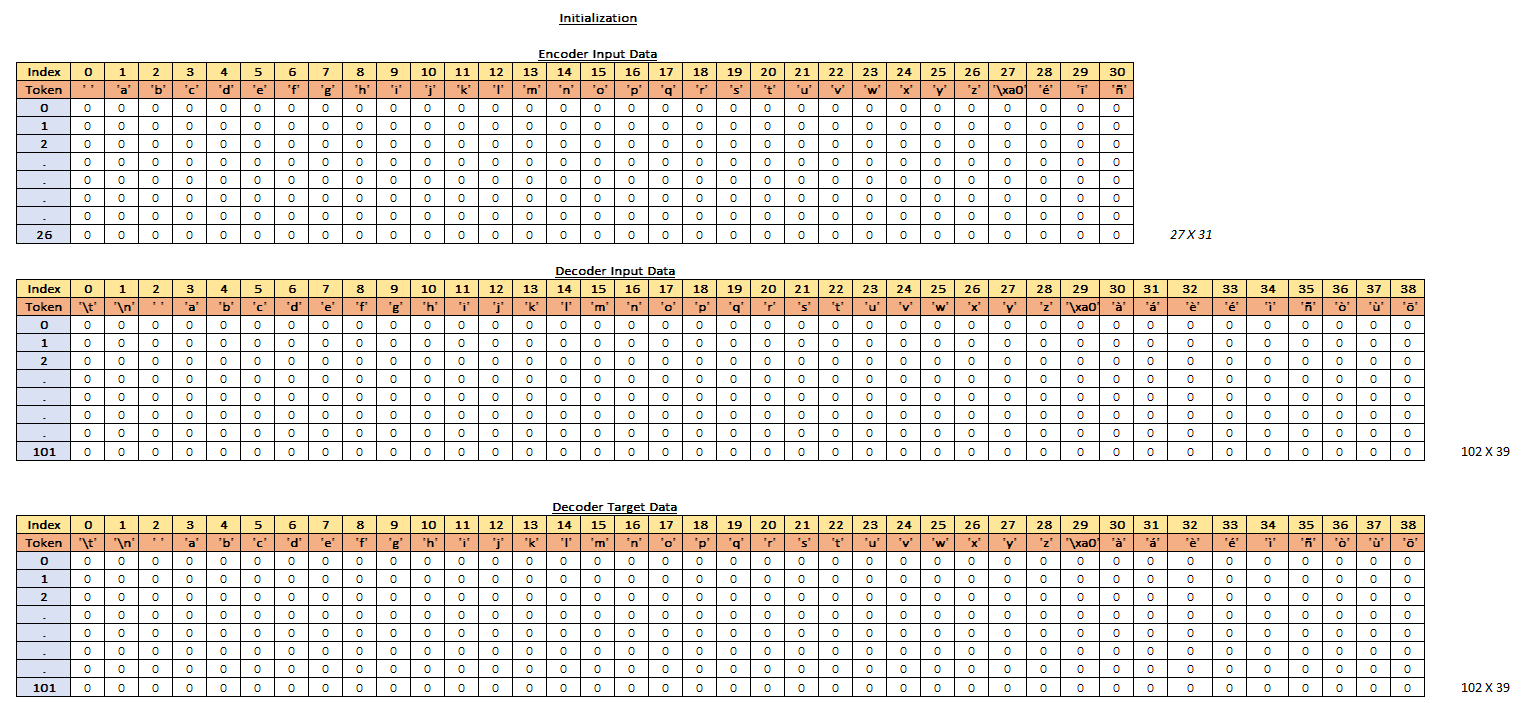

In [10]:
# Encoding
# Traversing over each sentence
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Traversing over each character in a sentence
    for t, char in enumerate(input_text):
        # Based on input token dictionary it will assign the value 1 in the respective index                                      
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # For remaining rows, value 1 will be assined corresponding to blank value/empty string                  
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0                
    for t, char in enumerate(target_text):
        # Based on input token dictionary it will assign the value 1 in the respective index
        decoder_input_data[i, t, target_token_index[char]] = 1.0          
        if t > 0:
            # decoder_target_data will be ahead by one timestep and will not include the start character                                                             
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    # For remaining rows, value 1 will be assined corresponding to blank value/empty string        
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0  
    # For remaining rows, value 1 will be assined corresponding to blank value/empty string               
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

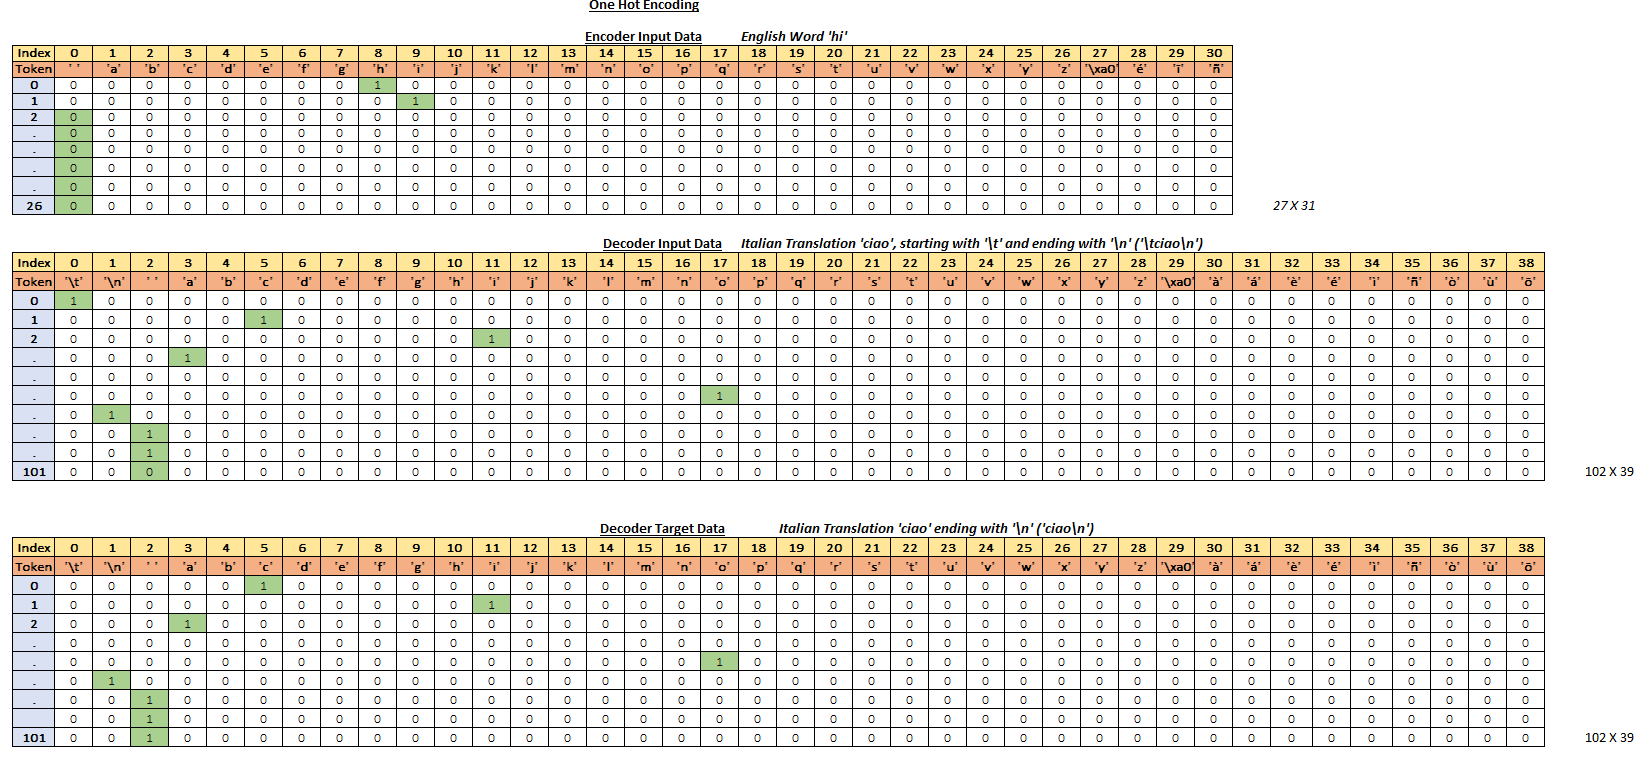

# Encoder Decoder Model

In [11]:
import tensorflow as tf

# Define an input sequence and process it
# Encoder part
encoder_inputs = tf.keras.Input(shape=(None, num_encoder_tokens))
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder part
decoder_inputs = tf.keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Train the model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
          x=[encoder_input_data, decoder_input_data],
          y=decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          )

Epoch 1/150
1250/1250 [==============================] - 35s 23ms/step - loss: 0.4487 - accuracy: 0.8647 - val_loss: 0.4367 - val_accuracy: 0.8620
Epoch 2/150
1250/1250 [==============================] - 28s 23ms/step - loss: 0.2835 - accuracy: 0.9115 - val_loss: 0.3375 - val_accuracy: 0.8950
Epoch 3/150
1250/1250 [==============================] - 28s 22ms/step - loss: 0.2335 - accuracy: 0.9272 - val_loss: 0.3031 - val_accuracy: 0.9056
Epoch 4/150
1250/1250 [==============================] - 28s 23ms/step - loss: 0.2085 - accuracy: 0.9347 - val_loss: 0.2813 - val_accuracy: 0.9122
Epoch 5/150
1250/1250 [==============================] - 28s 22ms/step - loss: 0.1930 - accuracy: 0.9393 - val_loss: 0.2704 - val_accuracy: 0.9156
Epoch 6/150
1250/1250 [==============================] - 28s 22ms/step - loss: 0.1819 - accuracy: 0.9426 - val_loss: 0.2622 - val_accuracy: 0.9186
Epoch 7/150
1250/1250 [==============================] - 28s 22ms/step - loss: 0.1733 - accuracy: 0.9451 - val_loss: 0

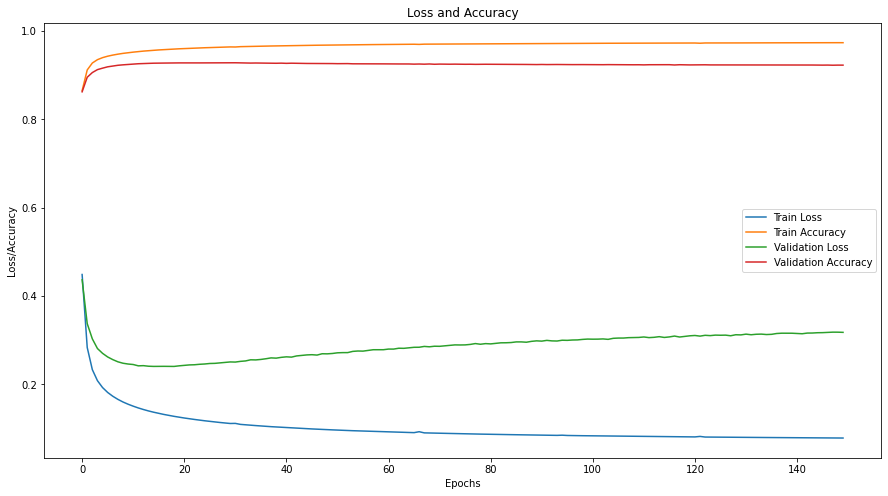

In [12]:
import pandas as pd

result = pd.DataFrame(model.history.history)
result.columns = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']
result.plot(title='Loss and Accuracy', xlabel = 'Epochs', ylabel='Loss/Accuracy', figsize=(15,8));

# Run Inference

In [13]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = tf.keras.Input(shape=(latent_dim,))
decoder_state_input_c = tf.keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [14]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [15]:
def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [17]:
def translate(idx):
  input_seq = encoder_input_data[idx : idx + 1]
  decoded_sentence = decode_sequence(input_seq)
  print("Input sentence in english:", input_texts[idx])
  print("Decoded sentence in italian:", decoded_sentence)

I have cross checked the output generated through encoder decoder model with google translate. The target sentences are matching.

In [20]:
translate(15)

Input sentence in english: jump
Decoded sentence in italian: saltate



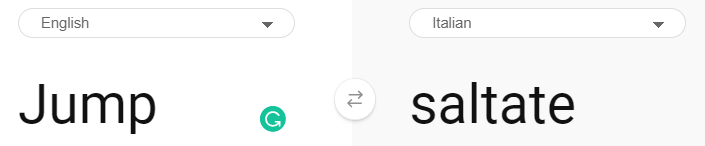

In [21]:
translate(50000)

Input sentence in english: ive forgiven you
Decoded sentence in italian: io lho perdonato



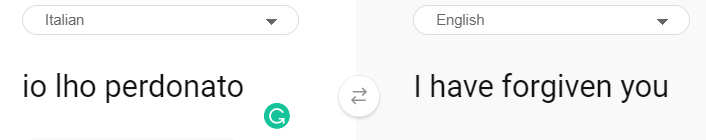

In [25]:
translate(60000)

Input sentence in english: i entered her room
Decoded sentence in italian: sono entrato nella sua stanza



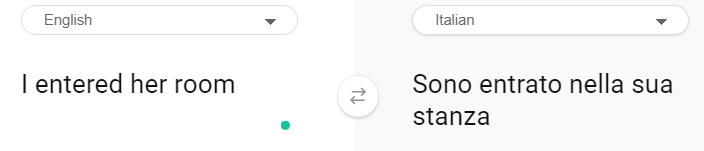